In [1]:
!pip install mediapipe -q
!pip install opencv-python -q
!pip install scikit-learn -q
!pip install wurlitzer -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
google-cloud-aiplatform 0.6.0a1 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-automl 1.0.1 requires google-api-core[grpc]<2.0.0dev,>=1.14.0, but you have google-api-core 2.11.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires protobuf<

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import random
import numpy as np
import pandas as pd
import mediapipe as mp
from torch.utils.data import Dataset, DataLoader


In [3]:
class HandKeypointDataset(Dataset):
    def __init__(self, csv_file, data_dir, label_map, mean, std, augment=False, augment_method=None):
        self.data_frame = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.label_map = label_map
        self.augment = augment
        self.augment_method = augment_method
        self.mean = mean.numpy() if isinstance(mean, torch.Tensor) else mean
        self.std = std.numpy() if isinstance(std, torch.Tensor) else std
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        video_id = row['video_id']
        label = row['label']
        frames = np.load(os.path.normpath(os.path.join(self.data_dir, f'{video_id}.npy')))
        label_idx = self.label_map[label]

        if self.augment and self.augment_method:
            frames = self.augment_method(frames)
        
        frames = self.normalize_frames(frames)
        return torch.tensor(frames, dtype=torch.float32), torch.tensor(label_idx, dtype=torch.long)

    def normalize_frames(self, frames):
        epsilon = 1e-8
        return (frames - self.mean) / (self.std + epsilon)

    
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    n_samples = 0

    for frames, _ in loader:
        frames = frames.view(frames.size(0), -1)
        mean += frames.mean(1).sum(0)
        std += frames.std(1).sum(0)
        n_samples += frames.size(0)

    mean /= n_samples
    std /= n_samples
    return mean, std




# 标签编码
labels = pd.read_csv('/kaggle/input/Updated_Train.csv')['label'].unique()
label_map = {label: idx for idx, label in enumerate(labels)}

# 初步创建数据集和数据加载器
csv_file = '/kaggle/input/Updated_Train.csv'
data_dir = '/kaggle/input/processed_train_new/processed_train'

train_dataset_initial = HandKeypointDataset(csv_file, data_dir, label_map, mean=0, std=1, augment=False)
train_loader_initial = DataLoader(train_dataset_initial, batch_size=32, shuffle=True, num_workers=4)

# 计算均值和标准差
train_mean, train_std = calculate_mean_std(train_loader_initial)
print(train_mean, train_std)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(0.1196) tensor(0.2007)


In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN

# 读取CSV文件
df = pd.read_csv(csv_file)

# 提取特征和标签
X = df['video_id'].values.reshape(-1, 1)
y = df['label'].values

# 使用上采样
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# 更新数据集
resampled_df = pd.DataFrame({'video_id': X_resampled.flatten(), 'label': y_resampled})
resampled_csv_file = 'Resampled_Train.csv'
resampled_df.to_csv(resampled_csv_file, index=False)

In [5]:
# 创建数据集和数据加载器
# train_dataset = HandKeypointDataset('/kaggle/input/gesture-data/Updated_Train.csv', '/kaggle/input/gesture-data/processed_train_new/processed_train', label_map, mean=train_mean, std=train_std, augment=False)
train_dataset = HandKeypointDataset(resampled_csv_file, data_dir, label_map, mean=train_mean, std=train_std, augment=False)
validation_dataset = HandKeypointDataset('/kaggle/input/Updated_Validation.csv', '/kaggle/input/processed_validation/processed_validation', label_map, mean=train_mean, std=train_std, augment=False)
test_dataset = HandKeypointDataset('/kaggle/input/Updated_Test_new.csv', '/kaggle/input/processed_test_new/processed_test', label_map, mean=train_mean, std=train_std, augment=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [6]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.context_vector = nn.Linear(hidden_size * 2, 1, bias=False)

    def forward(self, lstm_output):
        attn_weights = torch.tanh(self.attention(lstm_output))
        attn_weights = self.context_vector(attn_weights).squeeze(-1)
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(attn_weights.unsqueeze(-1) * lstm_output, dim=1)
        return context, attn_weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers, dropout_rate=0.3):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.attention = Attention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out)
        context = self.dropout(context)
        context = self.batch_norm(context)
        out = self.fc(context)
        return out

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_loss = None

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'早停计数: {self.counter} / {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        """当验证损失减少时保存模型。"""
        if self.verbose:
            print(f'验证损失减少 ({self.best_loss:.6f} --> {val_loss:.6f})。保存模型...')
        torch.save(model.state_dict(), path)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Using device: cuda
CUDA Available: True
Number of GPUs: 1
Current GPU: 0
GPU Name: Tesla P100-PCIE-16GB


In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(f'Using device: {device}')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='inference_feedback_manager')

# 或者将特定模块的日志级别设为 ERROR
import logging
logging.getLogger('inference_feedback_manager').setLevel(logging.ERROR)


# 检查数据样本
for inputs, labels in train_loader:
    print("Input shape:", inputs.shape)
    print("Label shape:", labels.shape)
    break



Using device: cuda


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Input shape: torch.Size([32, 37, 63])
Label shape: torch.Size([32])


In [10]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs, early_stopping, model_path='best_model.pth', checkpoint_interval=5, log_each_epoch=True, show_progress=True):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        if show_progress:
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} ', leave=False)
        else:
            progress_bar = train_loader

        for inputs, labels in progress_bar:
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if show_progress:
                progress_bar.set_postfix(loss=f'{loss.item():.4f}', accuracy=f'{(correct / total) * 100:.2f}%')

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        if log_each_epoch:
            print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.float().to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(validation_loader.dataset)
        val_losses.append(epoch_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        if log_each_epoch:
            print(f'Epoch {epoch + 1}/{num_epochs}  - Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            torch.save(model.state_dict(), model_path)
            print(f'Saved best model with loss: {best_val_loss:.4f}')

        scheduler.step()

        early_stopping(epoch_loss, model, model_path)

        if early_stopping.early_stop:
            print("Early Stopping")
            break

    model.load_state_dict(torch.load(model_path))
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [11]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # plt.tight_layout()
    plt.show()



In [12]:
print(label_map)

{'No gesture': 0, 'Pushing Two Fingers Away': 1, 'Sliding Two Fingers Down': 2, 'Pushing Hand Away': 3, 'Shaking Hand': 4, 'Pulling Two Fingers In': 5, 'Stop Sign': 6, 'Zooming In With Two Fingers': 7, 'Sliding Two Fingers Up': 8, 'Zooming Out With Two Fingers': 9, 'Zooming In With Full Hand': 10, 'Swiping Right': 11, 'Thumb Down': 12, 'Pulling Hand In': 13, 'Zooming Out With Full Hand': 14, 'Swiping Left': 15, 'Swiping Up': 16, 'Sliding Two Fingers Left': 17, 'Swiping Down': 18, 'Thumb Up': 19, 'Sliding Two Fingers Right': 20}


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Saved best model with loss: 0.8931
Saved best model with loss: 0.8259
Saved best model with loss: 0.7854
Saved best model with loss: 0.7677
Saved best model with loss: 0.7259
Saved best model with loss: 0.7025
Saved best model with loss: 0.6620


/tmp/ipykernel_36/1221497200.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Saved best model with loss: 0.8576
Saved best model with loss: 0.8298
Saved best model with loss: 0.7472
Saved best model with loss: 0.7447
Saved best model with loss: 0.7380
Saved best model with loss: 0.7252
Saved best model with loss: 0.7247
Saved best model with loss: 0.6700
Saved best model with loss: 0.8496
Saved best model with loss: 0.7625
Saved best model with loss: 0.7563
Saved best model with loss: 0.7457
Saved best model with loss: 0.7409
Saved best model with loss: 0.7405
Saved best model with loss: 0.7265
Saved best model with loss: 0.6646


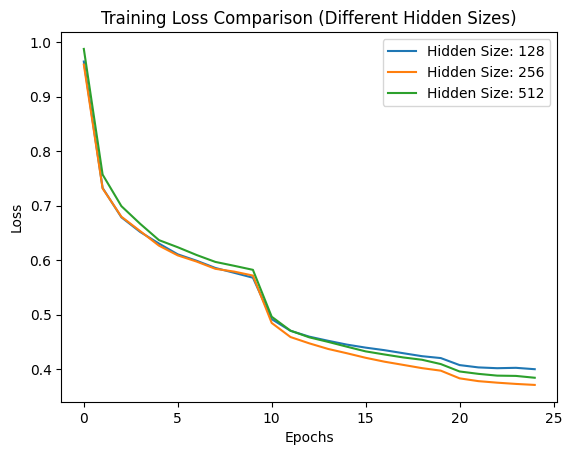

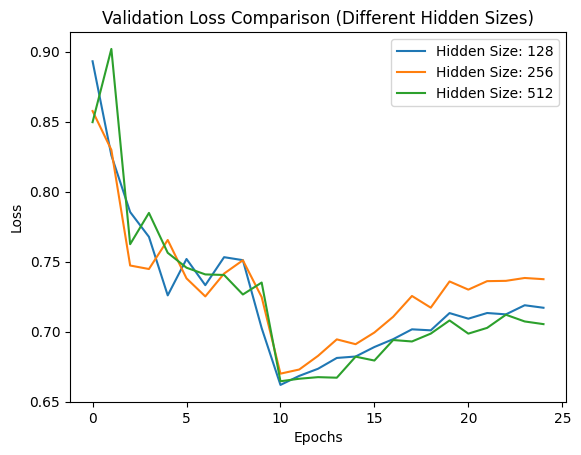

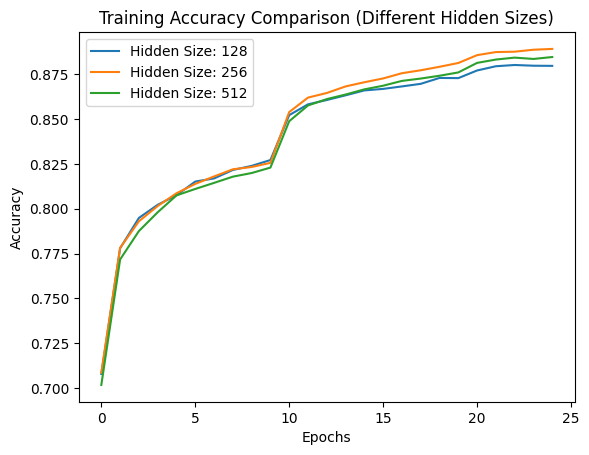

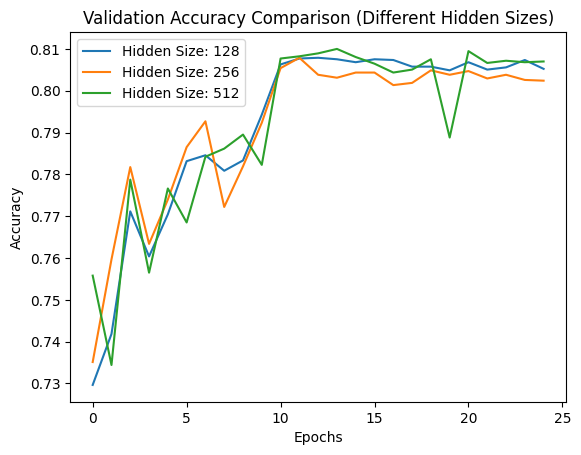

In [22]:
import matplotlib.pyplot as plt

# 假设不同的隐藏层神经元数量分别为128, 256, 512
hidden_sizes = [128, 256, 512]
input_size = 63  # 输入特征维度
output_size = 21  # 输出类别数量，根据实际情况调整
num_layers = 2  # LSTM层数量
dropout = 0.3  # Dropout率
lr = 0.001
weight_decay = 0.0001

train_losses_dict = {}
val_losses_dict = {}
train_acc_dict = {}
val_acc_dict = {}

for hidden_size in hidden_sizes:
    model = LSTMAttentionModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=output_size, dropout_rate=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=100, min_delta=0.01)

    
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, validation_loader, criterion, optimizer, num_epochs=25, early_stopping=early_stopping, log_each_epoch=False, show_progress=False
    )
    
    train_losses_dict[hidden_size] = train_losses
    val_losses_dict[hidden_size] = val_losses
    train_acc_dict[hidden_size] = train_accuracies
    val_acc_dict[hidden_size] = val_accuracies

# 绘制训练损失对比图
for hidden_size in hidden_sizes:
    plt.plot(train_losses_dict[hidden_size], label=f"Hidden Size: {hidden_size}")
plt.title('Training Loss Comparison (Different Hidden Sizes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证损失对比图
for hidden_size in hidden_sizes:
    plt.plot(val_losses_dict[hidden_size], label=f"Hidden Size: {hidden_size}")
plt.title('Validation Loss Comparison (Different Hidden Sizes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练准确率对比图
for hidden_size in hidden_sizes:
    plt.plot(train_acc_dict[hidden_size], label=f"Hidden Size: {hidden_size}")
plt.title('Training Accuracy Comparison (Different Hidden Sizes)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制验证准确率对比图
for hidden_size in hidden_sizes:
    plt.plot(val_acc_dict[hidden_size], label=f"Hidden Size: {hidden_size}")
plt.title('Validation Accuracy Comparison (Different Hidden Sizes)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Saved best model with loss: 0.8485
Saved best model with loss: 0.8356
Saved best model with loss: 0.7999
Saved best model with loss: 0.7346
Saved best model with loss: 0.7290
Saved best model with loss: 0.7251
Saved best model with loss: 0.6689


/tmp/ipykernel_36/1221497200.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Saved best model with loss: 0.9000
Saved best model with loss: 0.8334
Saved best model with loss: 0.8233
Saved best model with loss: 0.7529
Saved best model with loss: 0.7248
Saved best model with loss: 0.7228
Saved best model with loss: 0.6728
Saved best model with loss: 0.9070
Saved best model with loss: 0.8302
Saved best model with loss: 0.8287
Saved best model with loss: 0.7927
Saved best model with loss: 0.7220
Saved best model with loss: 0.6752


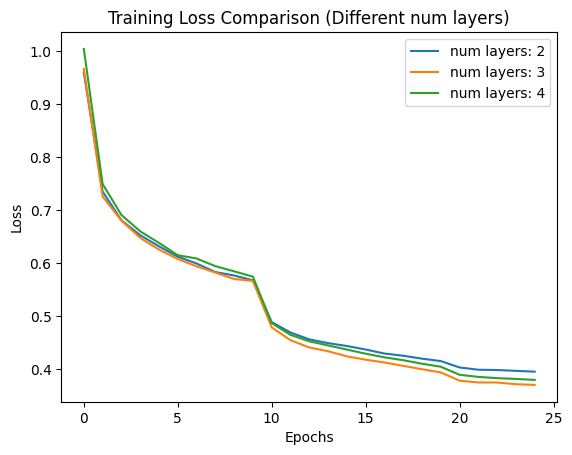

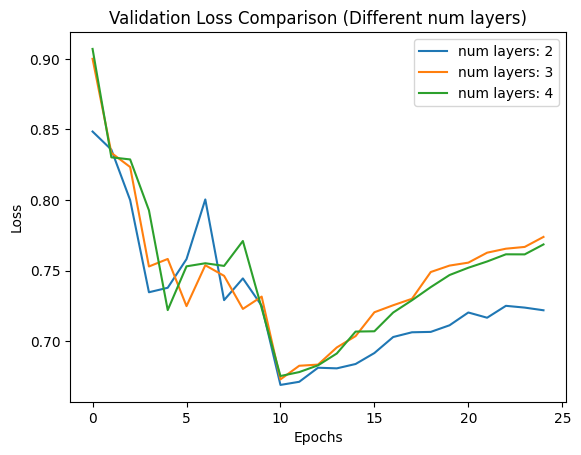

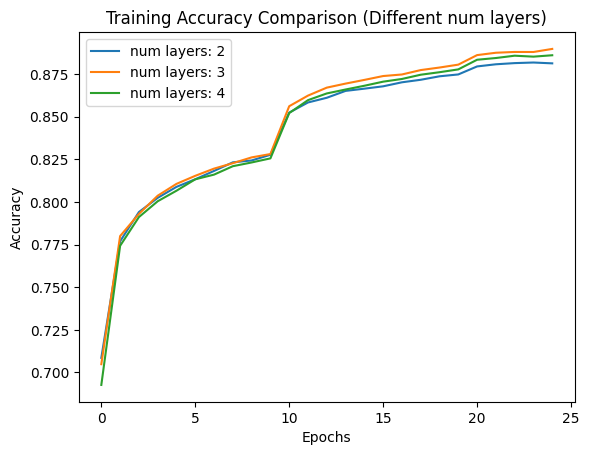

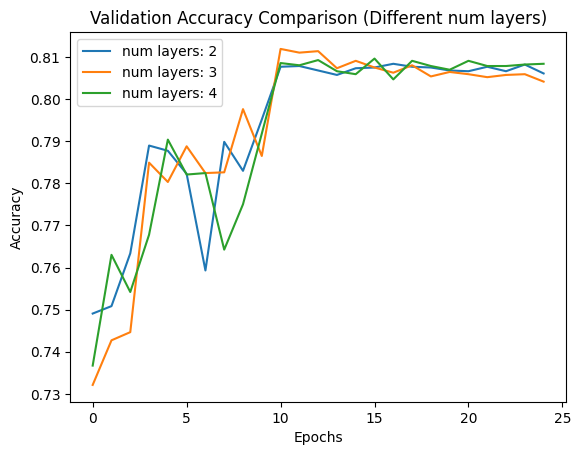

In [13]:
import matplotlib.pyplot as plt

# 假设不同的隐藏层神经元数量分别为128, 256, 512
hidden_size = 128
input_size = 63  # 输入特征维度
output_size = 21  # 输出类别数量，根据实际情况调整
num_layers = [2,3,4]  # LSTM层数量
dropout = 0.3  # Dropout率
lr = 0.001
weight_decay = 0.0001

train_losses_dict = {}
val_losses_dict = {}
train_acc_dict = {}
val_acc_dict = {}

for num_layer in num_layers:
    model = LSTMAttentionModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layer, num_classes=output_size, dropout_rate=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=100, min_delta=0.01)

    
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, validation_loader, criterion, optimizer, num_epochs=25, early_stopping=early_stopping, log_each_epoch=False, show_progress=False
    )
    
    train_losses_dict[num_layer] = train_losses
    val_losses_dict[num_layer] = val_losses
    train_acc_dict[num_layer] = train_accuracies
    val_acc_dict[num_layer] = val_accuracies

# 绘制训练损失对比图
for num_layer in num_layers:
    plt.plot(train_losses_dict[num_layer], label=f"num layers: {num_layer}")
plt.title('Training Loss Comparison (Different num layers)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证损失对比图
for num_layer in num_layers:
    plt.plot(val_losses_dict[num_layer], label=f"num layers: {num_layer}")
plt.title('Validation Loss Comparison (Different num layers)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练准确率对比图
for num_layer in num_layers:
    plt.plot(train_acc_dict[num_layer], label=f"num layers: {num_layer}")
plt.title('Training Accuracy Comparison (Different num layers)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制验证准确率对比图
for num_layer in num_layers:
    plt.plot(val_acc_dict[num_layer], label=f"num layers: {num_layer}")
plt.title('Validation Accuracy Comparison (Different num layers)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Saved best model with loss: 0.8702
Saved best model with loss: 0.8243
Saved best model with loss: 0.7992
Saved best model with loss: 0.7988
Saved best model with loss: 0.7672
Saved best model with loss: 0.7356
Saved best model with loss: 0.7040
Saved best model with loss: 0.6755
Saved best model with loss: 0.6737


/tmp/ipykernel_36/1221497200.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Saved best model with loss: 0.9200
Saved best model with loss: 0.8182
Saved best model with loss: 0.8003
Saved best model with loss: 0.7698
Saved best model with loss: 0.7460
Saved best model with loss: 0.7400
Saved best model with loss: 0.7248
Saved best model with loss: 1.7265
Saved best model with loss: 1.2625
Saved best model with loss: 1.0891
Saved best model with loss: 1.0033
Saved best model with loss: 0.9519
Saved best model with loss: 0.9273
Saved best model with loss: 0.8889
Saved best model with loss: 0.8600
Saved best model with loss: 0.8444
Saved best model with loss: 0.8422
Saved best model with loss: 0.8352
Saved best model with loss: 0.8283


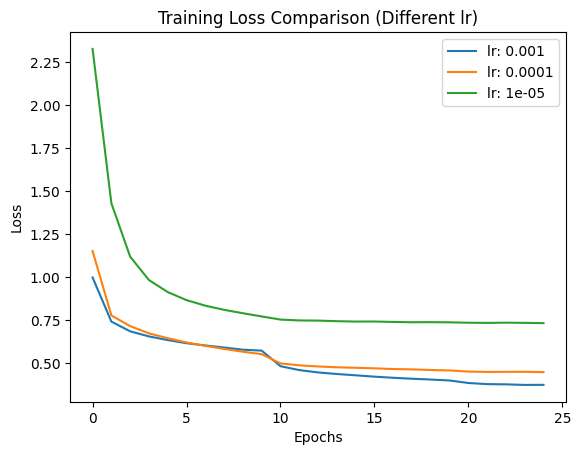

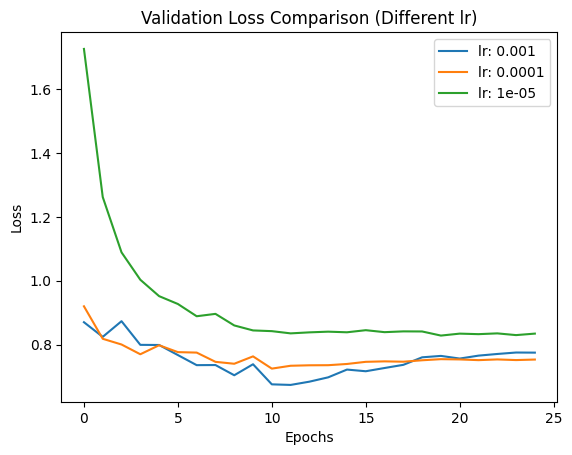

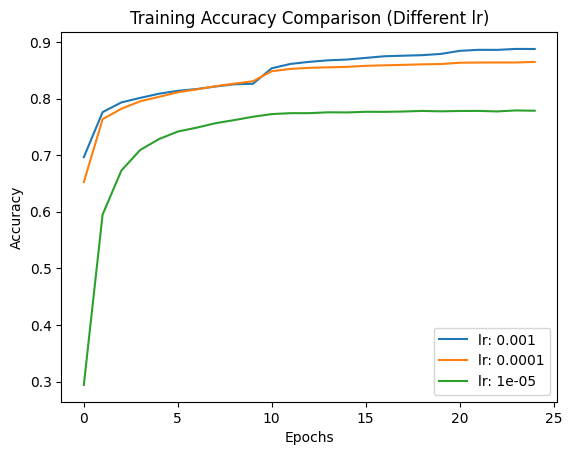

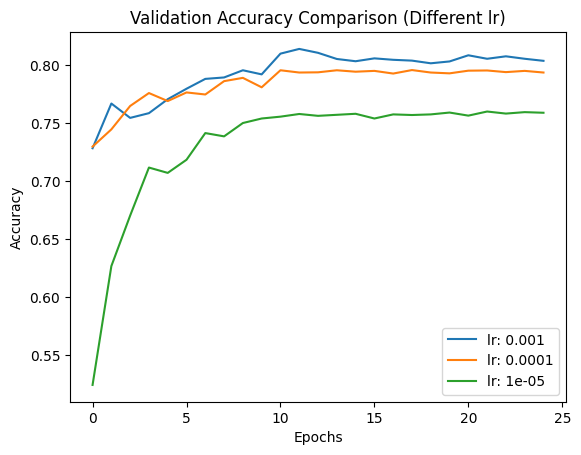

In [14]:
hidden_size = 128
input_size = 63  # 输入特征维度
output_size = 21  # 输出类别数量，根据实际情况调整
num_layers = 2  # LSTM层数量
dropout = 0.3  # Dropout率
lrs = [0.001, 0.0001, 0.00001]
weight_decay = 0.0001

train_losses_dict = {}
val_losses_dict = {}
train_acc_dict = {}
val_acc_dict = {}

for lr in lrs:
    model = LSTMAttentionModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layer, num_classes=output_size, dropout_rate=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=100, min_delta=0.01)

    
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, validation_loader, criterion, optimizer, num_epochs=25, early_stopping=early_stopping, log_each_epoch=False, show_progress=False
    )
    
    train_losses_dict[lr] = train_losses
    val_losses_dict[lr] = val_losses
    train_acc_dict[lr] = train_accuracies
    val_acc_dict[lr] = val_accuracies

# 绘制训练损失对比图
for lr in lrs:
    plt.plot(train_losses_dict[lr], label=f"lr: {lr}")
plt.title('Training Loss Comparison (Different lr)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证损失对比图
for lr in lrs:
    plt.plot(val_losses_dict[lr], label=f"lr: {lr}")
plt.title('Validation Loss Comparison (Different lr)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练准确率对比图
for lr in lrs:
    plt.plot(train_acc_dict[lr], label=f"lr: {lr}")
plt.title('Training Accuracy Comparison (Different lr)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制验证准确率对比图
for lr in lrs:
    plt.plot(val_acc_dict[lr], label=f"lr: {lr}")
plt.title('Validation Accuracy Comparison (Different lr)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


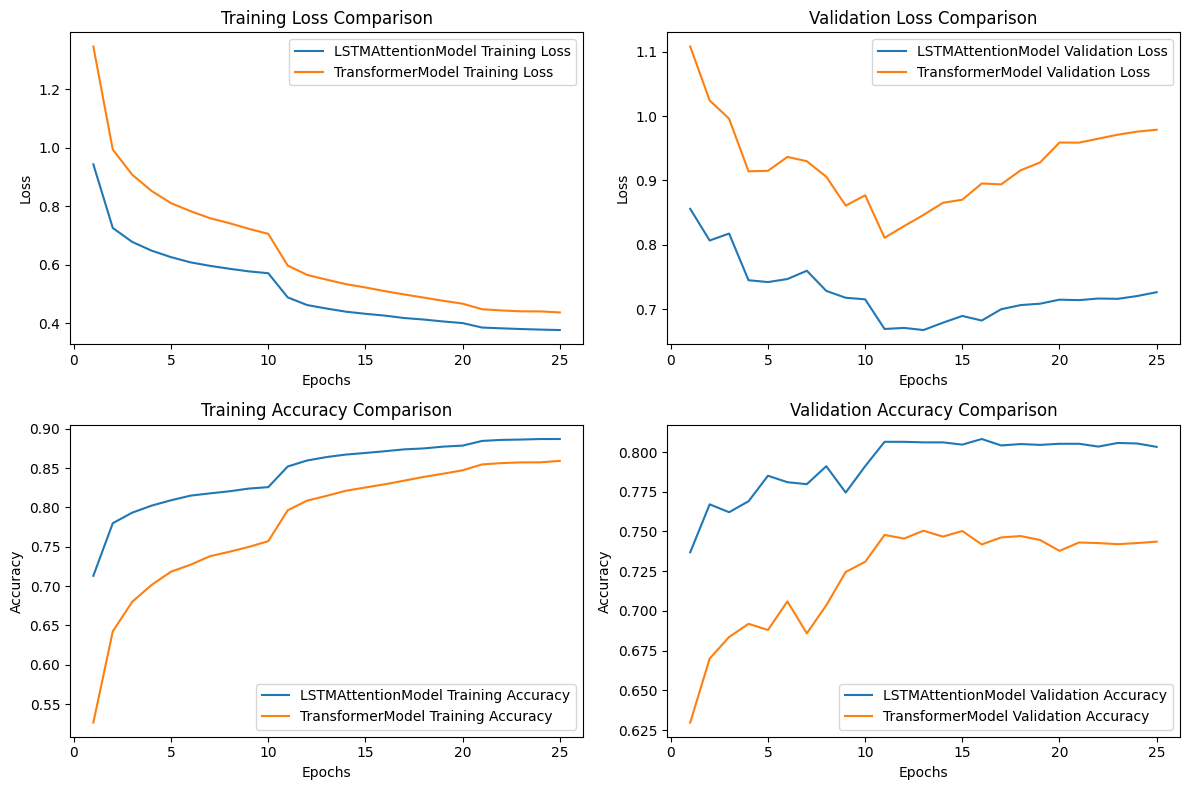

In [21]:
def plot_comparison_metrics(metrics1, metrics2, label1="Model 1", label2="Model 2"):
    epochs = range(1, len(metrics1['train_losses']) + 1)

    plt.figure(figsize=(12, 8))
    
    # Plot Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics1['train_losses'], label=f'{label1} Training Loss')
    plt.plot(epochs, metrics2['train_losses'], label=f'{label2} Training Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics1['val_losses'], label=f'{label1} Validation Loss')
    plt.plot(epochs, metrics2['val_losses'], label=f'{label2} Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics1['train_accuracies'], label=f'{label1} Training Accuracy')
    plt.plot(epochs, metrics2['train_accuracies'], label=f'{label2} Training Accuracy')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics1['val_accuracies'], label=f'{label1} Validation Accuracy')
    plt.plot(epochs, metrics2['val_accuracies'], label=f'{label2} Validation Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming that the training process for both models has been completed
# and the results (losses and accuracies) for the second model are stored similarly
metrics_model1 = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}

# After training model2, similar to how model1 was trained
# Assuming model2_results contains the train_losses, val_losses, train_accuracies, val_accuracies for model2
metrics_model2 = {
    'train_losses': train_losses_transformer,  # Replace with actual results
    'val_losses': val_losses_transformer,      # Replace with actual results
    'train_accuracies': train_accuracies_transformer,  # Replace with actual results
    'val_accuracies': val_accuracies_transformer       # Replace with actual results
}

# Plotting comparison
plot_comparison_metrics(metrics_model1, metrics_model2, label1="LSTMAttentionModel", label2="TransformerModel")

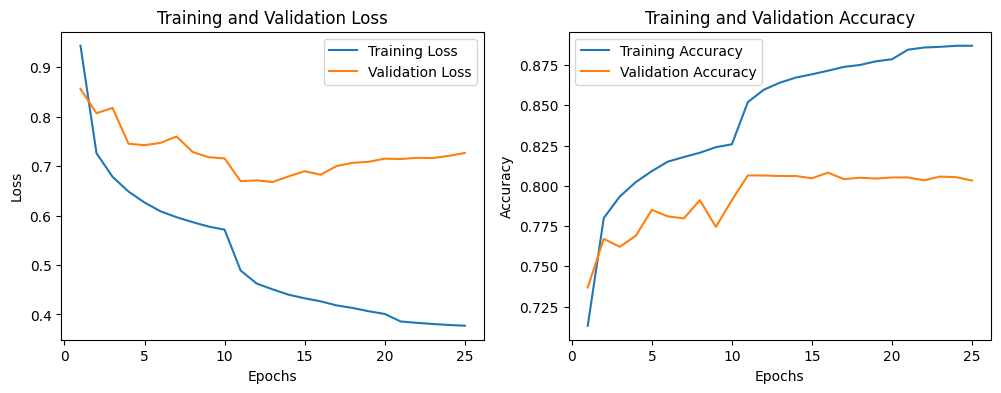

In [22]:
# 绘制训练和验证损失及准确率曲线
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


def evaluate_model(model, data_loader, label_map, show_confusion_matrix=True):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    if show_confusion_matrix:
        # 绘制混淆矩阵
        cm = confusion_matrix(all_labels, all_predictions, labels=list(label_map.values()))
        fig, ax = plt.subplots(figsize=(15, 15))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
        plt.show()

    return accuracy, precision, recall, f1

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.8099
Precision: 0.8475
Recall: 0.8099
F1 Score: 0.8194


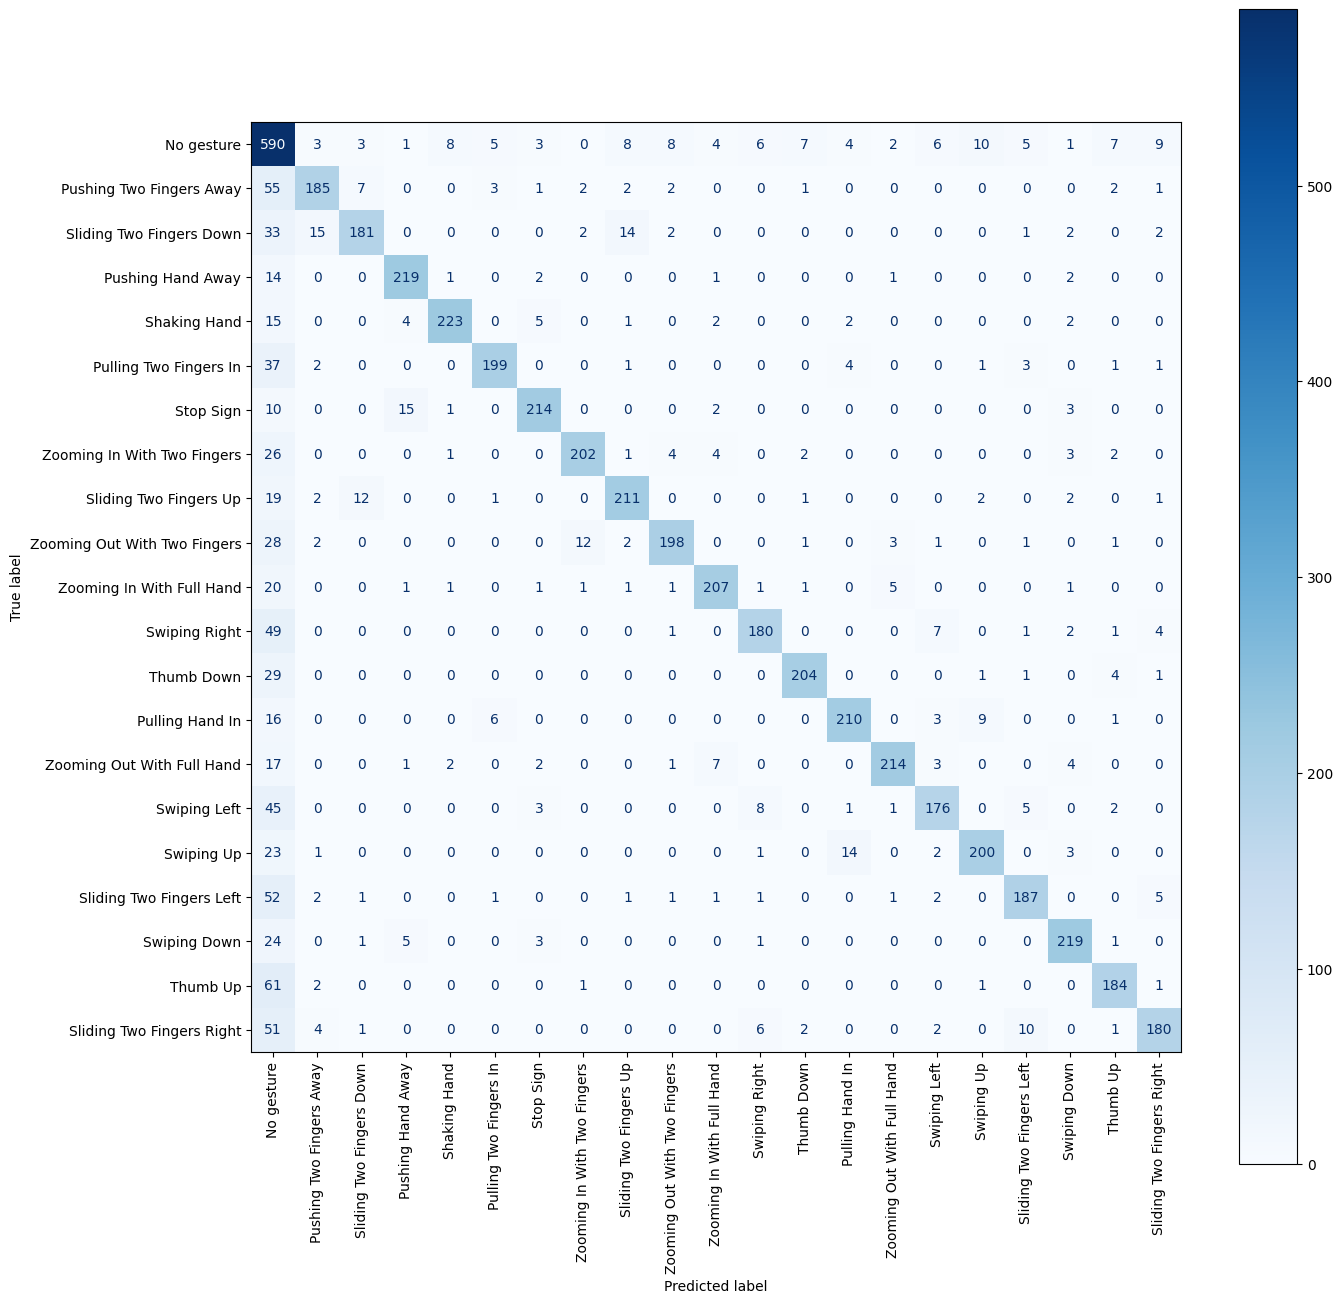

In [24]:
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, label_map, show_confusion_matrix=True)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.7487
Precision: 0.7783
Recall: 0.7487
F1 Score: 0.7539


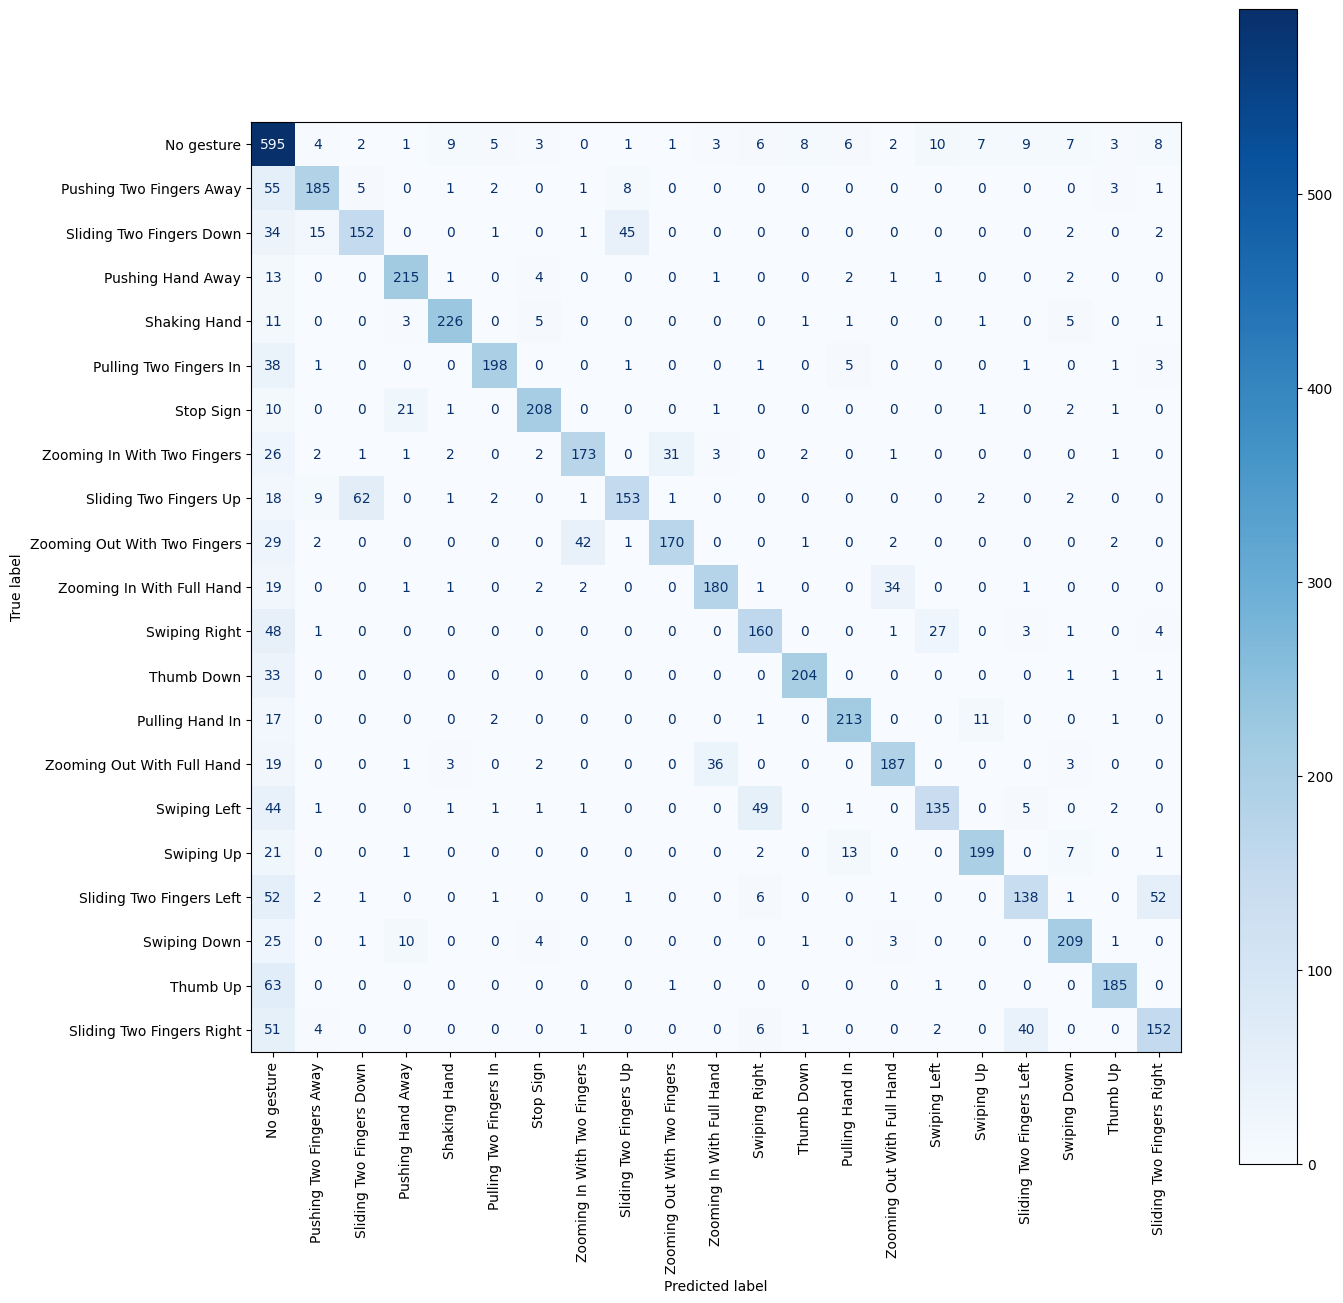

In [25]:
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model2, test_loader, label_map, show_confusion_matrix=True)